In [30]:
print "Stock Prediction using Lstm"

Stock Prediction using Lstm


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import datetime

In [32]:
def get_stock_data(stock_name, normalized=0):
    #getting todays date
    today=datetime.datetime.now()
    #dictionary for the months for Google Finance API
    month={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
    
    url="http://www.google.com/finance/historical?q="+stock_name+"&startdate="+month[today.month]+"+"+str(today.day)+"%2C+"+str(today.year-3)+"&enddate="+month[today.month]+"+"+str(today.day)+"%2C+"+str(today.year)+"&num=30&ei=rCtlWZGSFN3KsQHwrqWQCw&output=csv"
    
    col_names = ['Date','Open','High','Low','Close','Volume']
    stocks = pd.read_csv(url, header=0, names=col_names) 
    df = pd.DataFrame(stocks)
    df_date=df.copy()
    df.drop(df.columns[[0,3,5]], axis=1, inplace=True)
    df_date.drop(df_date.columns[[3,5]], axis=1, inplace=True)
    return df,df_date

In [33]:
stock_name = 'GOOGL'
df,df_date= get_stock_data(stock_name,0)
print "df---------------------------"
print df.tail()
print "df with date-----------------"
print df_date.tail()

df---------------------------
       Open    High   Close
751  599.49  605.40  605.40
752  595.05  597.56  597.27
753  589.51  596.07  593.29
754  580.95  590.15  588.78
755  582.24  583.92  581.64
df with date-----------------
          Date    Open    High   Close
751  19-Sep-14  599.49  605.40  605.40
752  18-Sep-14  595.05  597.56  597.27
753  17-Sep-14  589.51  596.07  593.29
754  16-Sep-14  580.95  590.15  588.78
755  15-Sep-14  582.24  583.92  581.64


In [34]:
maxhigh=max(df['High'])
maxclose=max(df['Close'])
maxopen=max(df['Open'])
df['High']=df['High']/max(df['High'])
df['Close']=df['Close']/max(df['Close'])
df['Open']=df['Open']/max(df['Open'])
print df.head()

       Open      High     Close
0  0.940338  0.944716  0.946389
1  0.941750  0.939987  0.942616
2  0.942028  0.944547  0.939270
3  0.944515  0.942584  0.937398
4  0.939094  0.942386  0.945842


In [35]:
def model_data(stock,seq_len):
    features=len(stock.columns)
    data=stock.as_matrix()
    print data

In [36]:
#main lstm !--! Yo ready for work
def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,init='uniform',activation='relu'))        
        model.add(Dense(1,init='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

In [37]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [38]:
window = 5
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

('X_train', (675, 5, 3))
('y_train', (675,))
('X_test', (75, 5, 3))
('y_test', (75,))


In [39]:
model = build_model2([3,window,1])

model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=500,
    validation_split=0.1,
    verbose=0)

/home/siddharth/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
/home/siddharth/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`


In [40]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.02 RMSE)
Test Score: 0.00 MSE (0.03 RMSE)


In [41]:
diff=[]
ratio=[]
p = model.predict(X_test)
print "index","actual","error","difference"
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    k=((y_test[u]/pr)-1)*100
    print(u, y_test[u], pr, k, abs(y_test[u]- pr))

index actual error difference
(0, 0.98903692197395154, 0.93092936, 6.2418870350069211, 0.05810755920005628)
(1, 0.99192456287091246, 0.93690711, 5.8722417124049686, 0.055017450272493273)
(2, 0.9828832596487036, 0.94297576, 4.2320812322232948, 0.039907500142478014)
(3, 0.98407814553710116, 0.94777149, 3.8307394044361009, 0.036306655916892416)
(4, 0.99187477595889595, 0.95182014, 4.2082153302433589, 0.040054640842318801)
(5, 0.99960170470386744, 0.95296526, 4.893824269500624, 0.046636445151865491)
(6, 0.99243238937348144, 0.95330137, 4.1047899914047781, 0.039131019229591057)
(7, 0.99732146413350864, 0.9536339, 4.5811667844682935, 0.043687559676416354)
(8, 1.0, 0.95476395, 4.7379303684334184, 0.045236051082611084)
(9, 0.96598558171028004, 0.95748949, 0.88732996920206642, 0.0084960912012468359)
(10, 0.95771099693312622, 0.95932555, -0.16830105799063855, 0.0016145550535681119)
(11, 0.96636396224160592, 0.95691198, 0.98775867816796037, 0.0094519811358014794)
(12, 0.96380491496395426, 0.95301

In [42]:
size=len(ratio)
error=sum(ratio)/size
print "average error rate :",error*100

average error rate : 2.79916108611


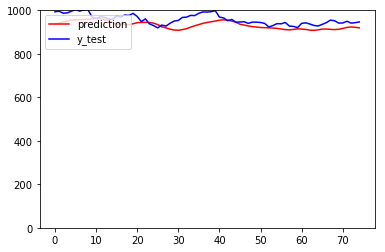

In [43]:
import matplotlib.pyplot as plt2

plt2.plot(p*maxclose,color='red', label='prediction')
plt2.plot(y_test*maxclose,color='blue', label='y_test')
plt2.ylim([0,1000])
plt2.legend(loc='upper left')
plt2.show()

In [44]:
#to do
#work on google finance collect financial news data mix with other data

In [45]:
 print "next time"

next time
